In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [28]:
data_train=pd.read_csv("fraudTrain.csv")
data_test=pd.read_csv("fraudTest.csv")

In [29]:
full_data=pd.concat([data_train, data_test])

In [30]:
full_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [31]:
print(full_data.dtypes)

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


In [32]:

sampled_df = full_data.sample(frac=0.1) 

print(sampled_df.columns)


Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [33]:
full_data.drop(columns = [full_data.columns[0], full_data.columns[2], full_data.columns[6], full_data.columns[7], full_data.columns[9]], inplace=True)

In [34]:
full_data.head(2)

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [35]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c
full_data["distance"] = full_data.apply(lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

In [36]:
full_data["dob"] = pd.to_datetime(full_data["dob"])
# Define a function to calculate age
from datetime import datetime
def calculate_age(dob):
    today = datetime.today()
    age = today.year - dob.year
    if (today.month, today.day) < (dob.month, dob.day):
        age -= 1
    return age

In [37]:
full_data['age'] = full_data['dob'].apply(calculate_age)
full_data.drop(columns = ["dob"], inplace = True)
full_data.sample(2)

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,age
1107679,2020-04-06 02:37:50,fraud_Harber Inc,gas_transport,62.57,F,Alpharetta,GA,30009,34.0770,-84.3033,165556,Prison officer,3f482d138df20b504e01aede35694800,1365215870,34.069796,-84.832794,0,48.775591,26
534375,2019-08-17 23:36:02,"fraud_Becker, Harris and Harvey",personal_care,43.12,F,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,0d493f0c4df3a2a70f09a5b20b774d23,1345246562,45.513711,-119.411790,0,85.594367,43


In [38]:
full_data["trans_date_trans_time"] = pd.to_datetime(full_data["trans_date_trans_time"])
full_data["is_weekend"] = full_data["trans_date_trans_time"].dt.day_name().apply(lambda x : int((x == "Friday") | (x == "Sunday") | (x == "saturday")))
def day_period(x):
    if x >=0 and x < 6: return "Night"
    elif x>= 6 and x <= 12: return "Morning"
    elif x> 12 and x <= 15: return "Afternoon"
    elif x> 15 and x <= 20: return "Evening"
    elif x> 20 and x <= 24: return "Night"
full_data["day_period"] = full_data["trans_date_trans_time"].dt.hour.apply(day_period)
full_data["trans_month"] = full_data["trans_date_trans_time"].dt.month_name()

full_data.drop(columns = ["trans_date_trans_time"], inplace = True)
full_data.sample(2)

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,age,is_weekend,day_period,trans_month
259873,"fraud_Feil, Hilpert and Koss",food_dining,9.96,F,Viola,AR,72583,36.3924,-91.9932,1679,...,0ac860a189abf0f14ad6df7fd0229bb2,1336580229,36.235965,-92.364655,0,37.553461,38,0,Evening,May
460442,fraud_Bruen-Yost,misc_pos,2.94,F,Mill Creek,PA,17060,40.4679,-77.8967,1334,...,e6e727ea20d96ca15452510aa0cb6f22,1386716336,40.033760,-76.919512,0,95.956761,37,0,Night,December


In [39]:
numerical = ["amt", "city_pop", "distance", "age"]
categorical = ["category","gender","is_weekend","trans_month","day_period"]
categorical, numerical

(['category', 'gender', 'is_weekend', 'trans_month', 'day_period'],
 ['amt', 'city_pop', 'distance', 'age'])

In [40]:
# Step 1: Calculate fraud percentages for each merchant
merchant_groups = full_data.groupby('merchant')
fraud_percentage_dict = {}

for merchant, group in merchant_groups:
    total_trans = group.shape[0]
    total_fraud_trans = group[group["is_fraud"] == 1].shape[0]
    fraud_percentage_dict[merchant] = (total_fraud_trans / total_trans) * 100

# Step 2: Map the calculated percentages back to the DataFrame
full_data["fraud_merchant_pct"] = full_data["merchant"].map(fraud_percentage_dict)

In [41]:
# Step 1: Rank merchants based on their fraud percentages
# Sort fraud_percentage_dict by fraud percentage
sorted_fraud_percentage = sorted(fraud_percentage_dict.items(), key=lambda x: x[1])

# Create a dictionary for ordinal encoding
merchant_ordinal_dict = {merchant: rank + 1 for rank, (merchant, _) in enumerate(sorted_fraud_percentage)}

# Step 2: Map the ordinal encoding back to the DataFrame
full_data["merchant_ordinal"] = full_data["merchant"].map(merchant_ordinal_dict)

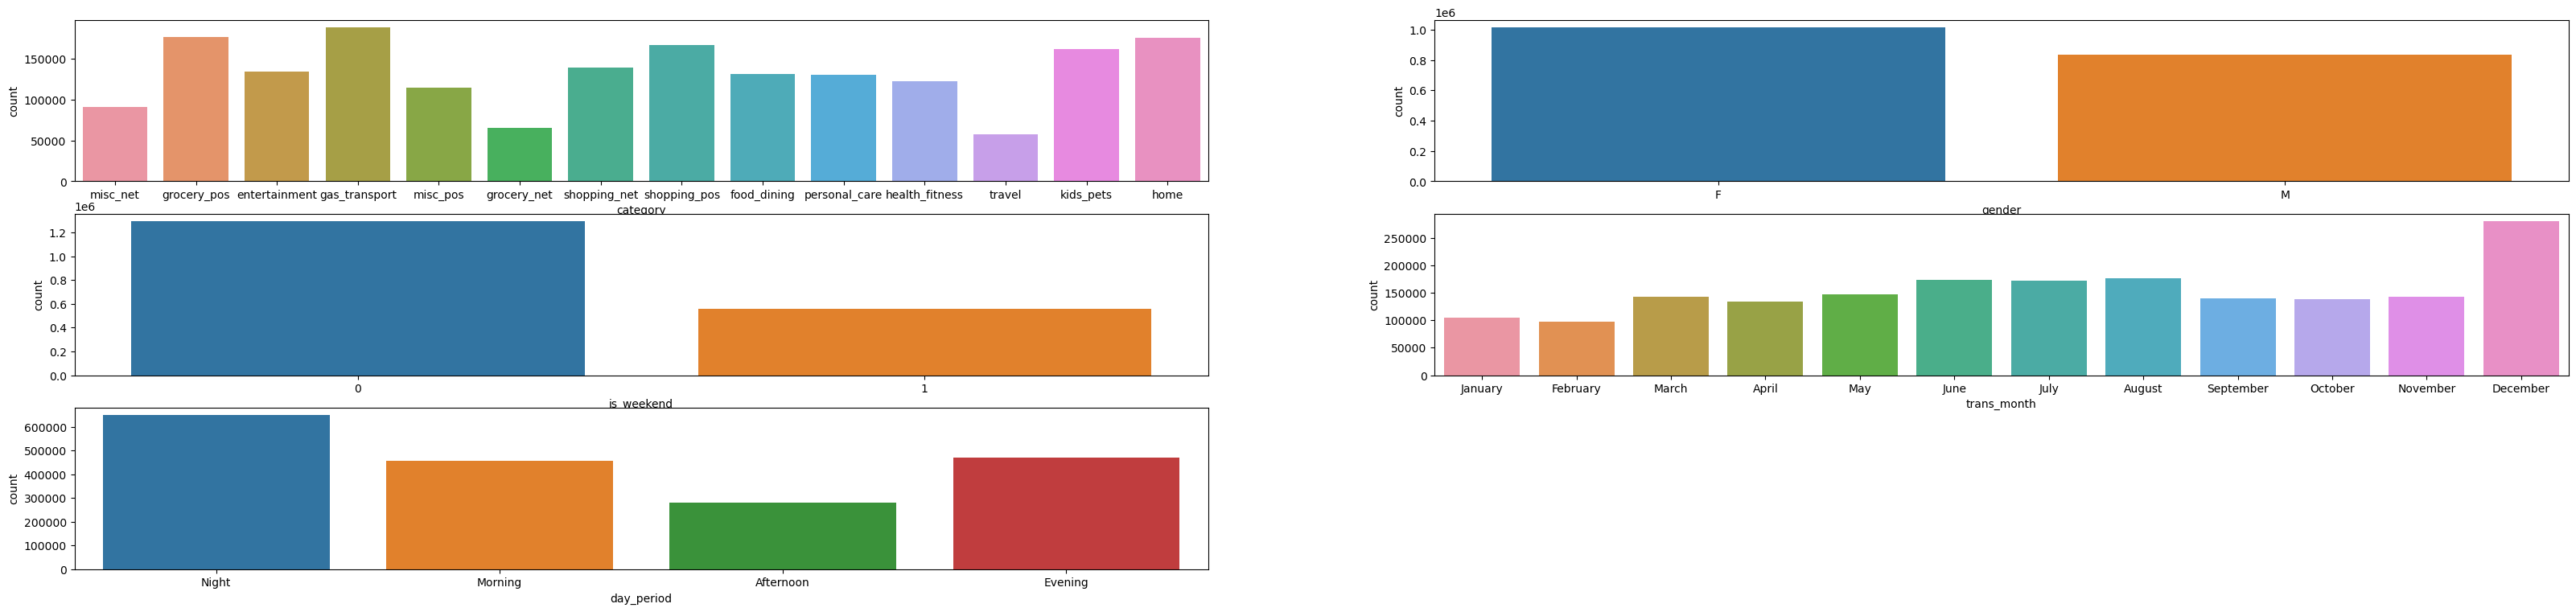

In [42]:
plt.figure(figsize = (40, 12))
cnt = 0
for column in categorical:
    cnt += 1
    plt.subplot(4, 2, cnt)
    sns.countplot(x = full_data[column])

In [43]:
 for column in categorical:
    cnt += 1
   

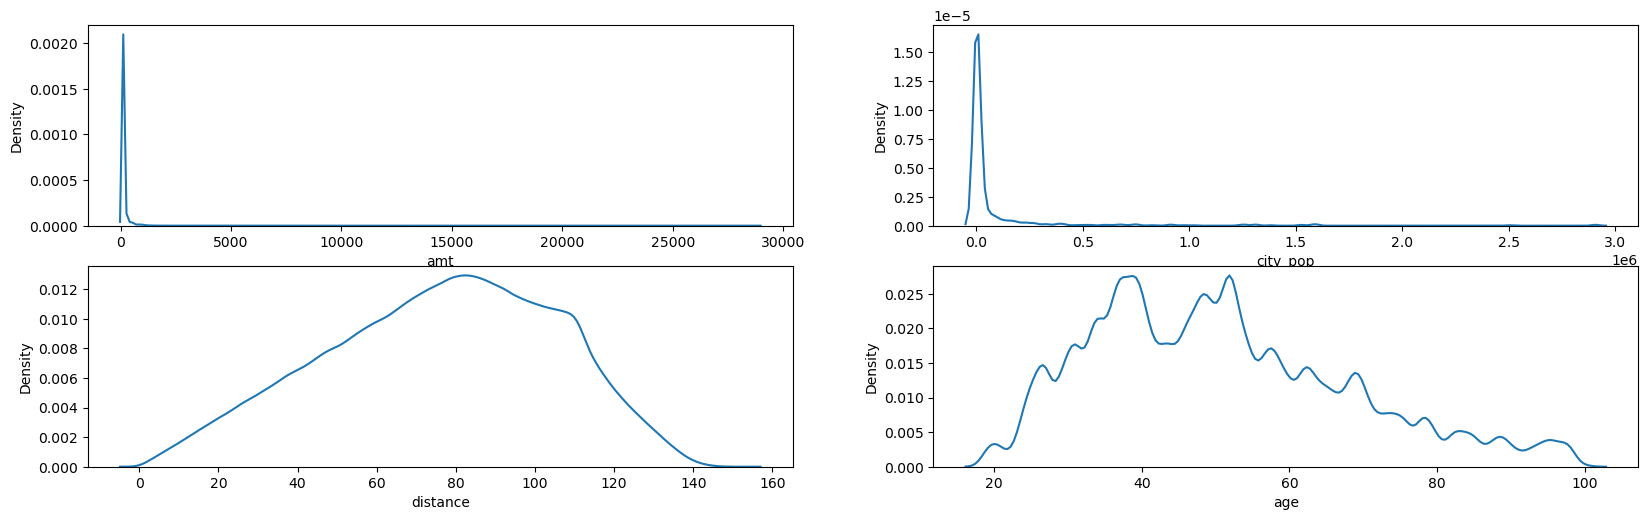

In [44]:
plt.figure(figsize = (20, 12))
cnt = 0
for column in numerical:
    cnt += 1
    plt.subplot(4, 2, cnt)
    sns.kdeplot(x = full_data[column])

In [45]:
for col in numerical:
    print(f"col = {col}\tskewness = {full_data[col].skew()}")

col = amt	skewness = 40.81280917629574
col = city_pop	skewness = 5.590804561529247
col = distance	skewness = -0.235677392216978
col = age	skewness = 0.6129275707296262


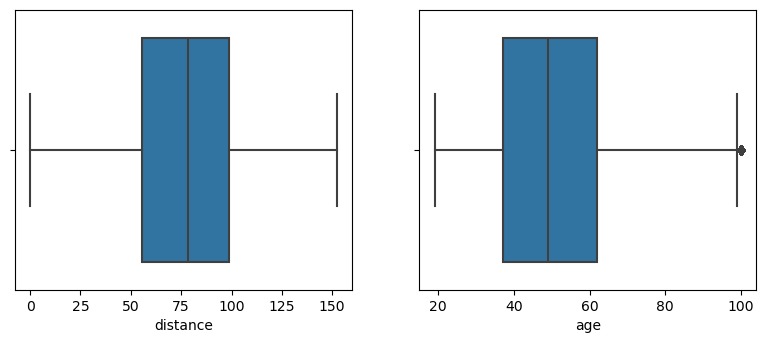

In [46]:
plt.figure(figsize = (20, 8))
cnt = 0
for column in ["distance","age"]:
    cnt += 1
    plt.subplot(2, 4, cnt)
    sns.boxplot(x = full_data[column])

<Axes: >

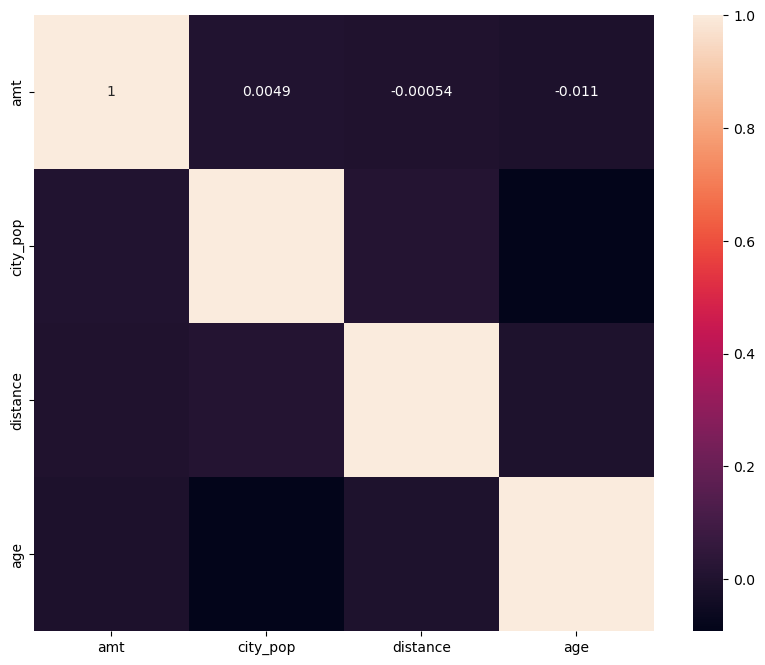

In [47]:
plt.figure(figsize = (10,8))
sns.heatmap(data = full_data[numerical].corr(), annot = True)

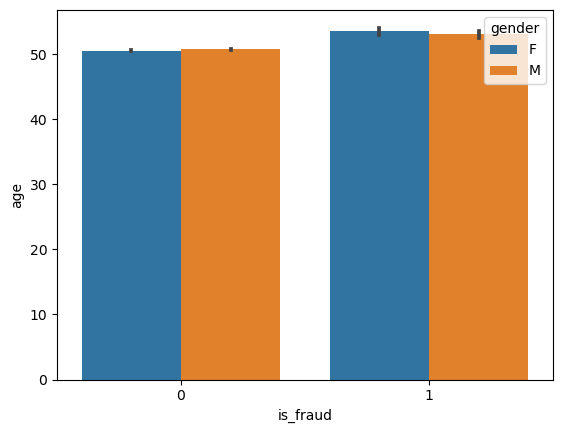

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'gender' is treated as a categorical variable
full_data["gender"] = full_data["gender"].astype(str)

# Create the barplot
sns.barplot(y=full_data["age"], x=full_data["is_fraud"], hue=full_data["gender"])

# Display the plot
plt.show()


In [49]:
# Step 1: Calculate fraud percentages for each merchant
merchant_groups = full_data.groupby('merchant')
fraud_percentage_dict = {}

for merchant, group in merchant_groups:
    total_trans = group.shape[0]
    total_fraud_trans = group[group["is_fraud"] == 1].shape[0]
    fraud_percentage_dict[merchant] = (total_fraud_trans / total_trans) * 100

# Step 2: Map the calculated percentages back to the DataFrame
full_data["fraud_merchant_pct"] = full_data["merchant"].map(fraud_percentage_dict)

In [50]:
# Step 1: Rank merchants based on their fraud percentages
# Sort fraud_percentage_dict by fraud percentage
sorted_fraud_percentage = sorted(fraud_percentage_dict.items(), key=lambda x: x[1])

# Create a dictionary for ordinal encoding
merchant_ordinal_dict = {merchant: rank + 1 for rank, (merchant, _) in enumerate(sorted_fraud_percentage)}

# Step 2: Map the ordinal encoding back to the DataFrame
full_data["merchant_ordinal"] = full_data["merchant"].map(merchant_ordinal_dict)

<Axes: xlabel='is_fraud', ylabel='fraud_merchant_pct'>

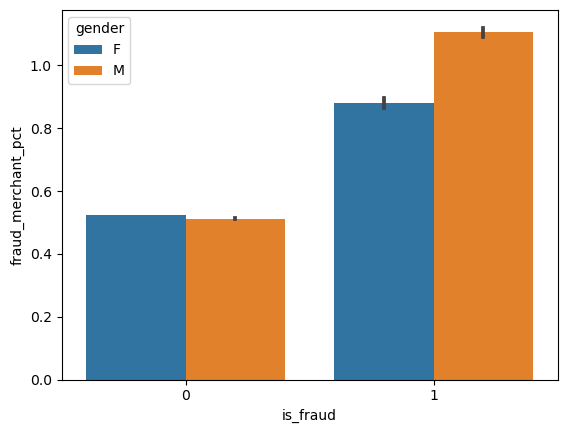

In [51]:
sns.barplot(y = full_data["fraud_merchant_pct"], x=full_data["is_fraud"], hue = full_data["gender"])

<Axes: xlabel='is_weekend', ylabel='amt'>

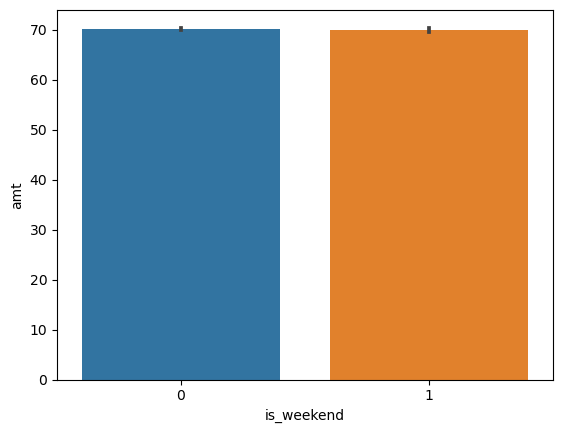

In [52]:
sns.barplot(y = full_data["amt"], x=full_data["is_weekend"])

<Axes: xlabel='trans_month', ylabel='amt'>

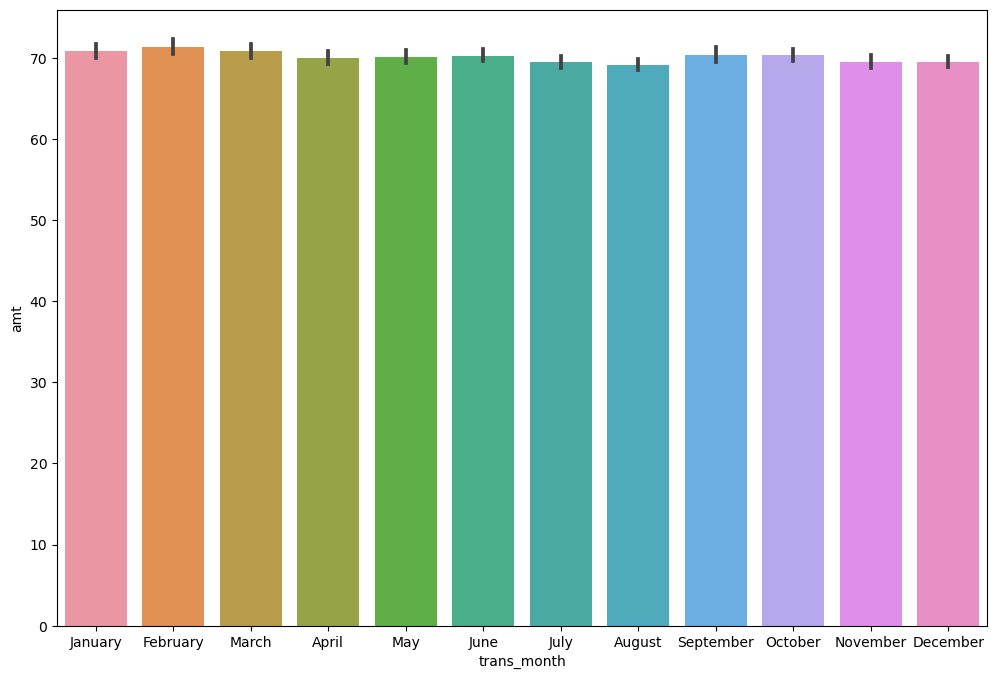

In [53]:
plt.figure(figsize = (12, 8))
sns.barplot(y = full_data["amt"], x=full_data["trans_month"])

<Axes: xlabel='category', ylabel='fraud_merchant_pct'>

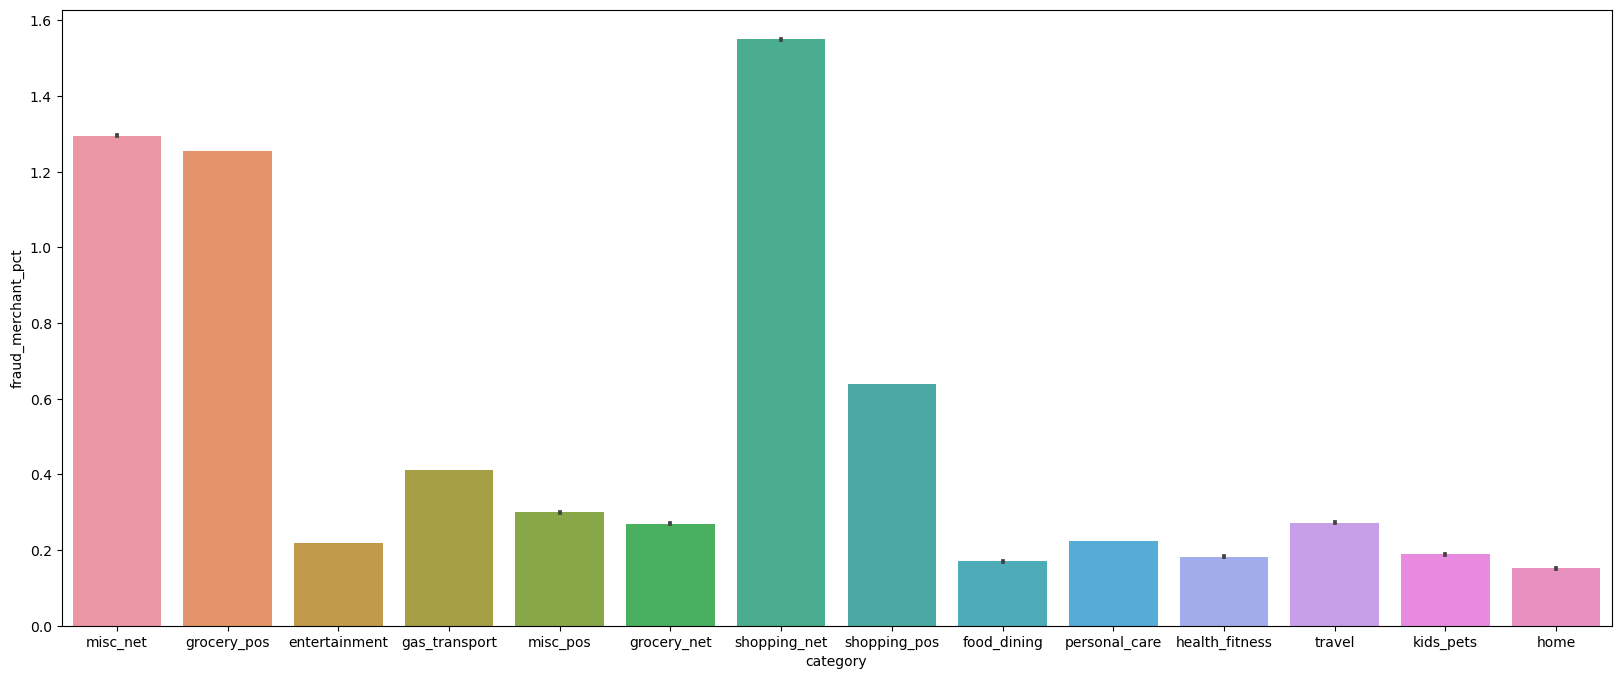

In [54]:
plt.figure(figsize = (20, 8))
sns.barplot(y = full_data["fraud_merchant_pct"], x=full_data["category"])

<Axes: xlabel='day_period', ylabel='amt'>

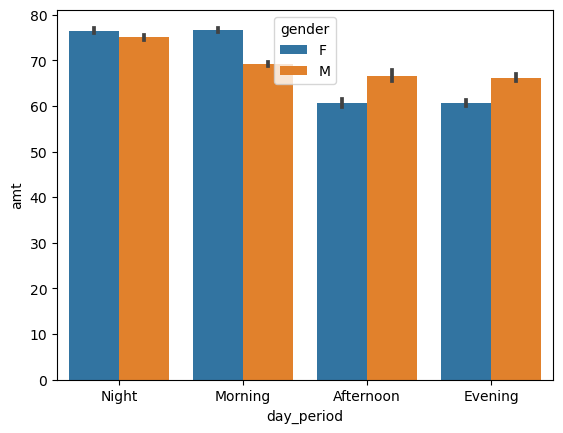

In [55]:
# plt.figure(figsize = (12, 8))
sns.barplot(y = full_data["amt"], x=full_data["day_period"], hue = full_data["gender"])

<Axes: xlabel='is_fraud', ylabel='category'>

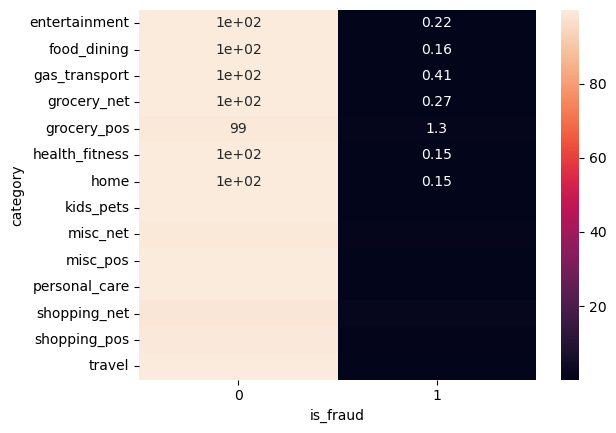

In [56]:
sns.heatmap(data=pd.crosstab(full_data["category"],full_data["is_fraud"], normalize = "index") * 100, annot = True)

<Axes: title={'center': 'Transaction Type Distribution'}, xlabel='category'>

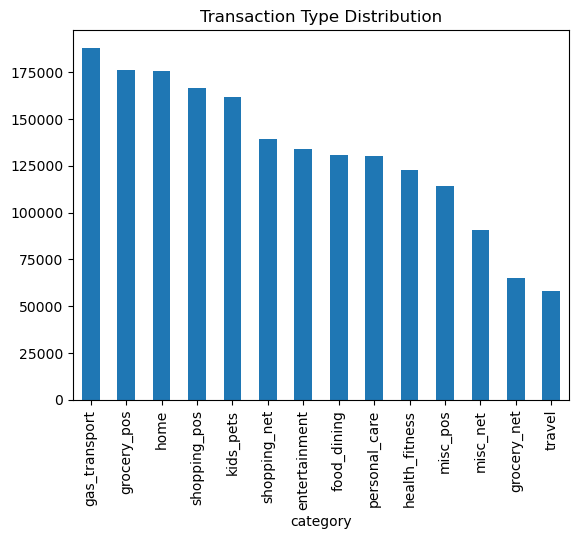

In [57]:
full_data['category'] = full_data['category'].astype('category')

transaction_counts = full_data['category'].value_counts()
transaction_counts.plot(kind='bar', title='Transaction Type Distribution')

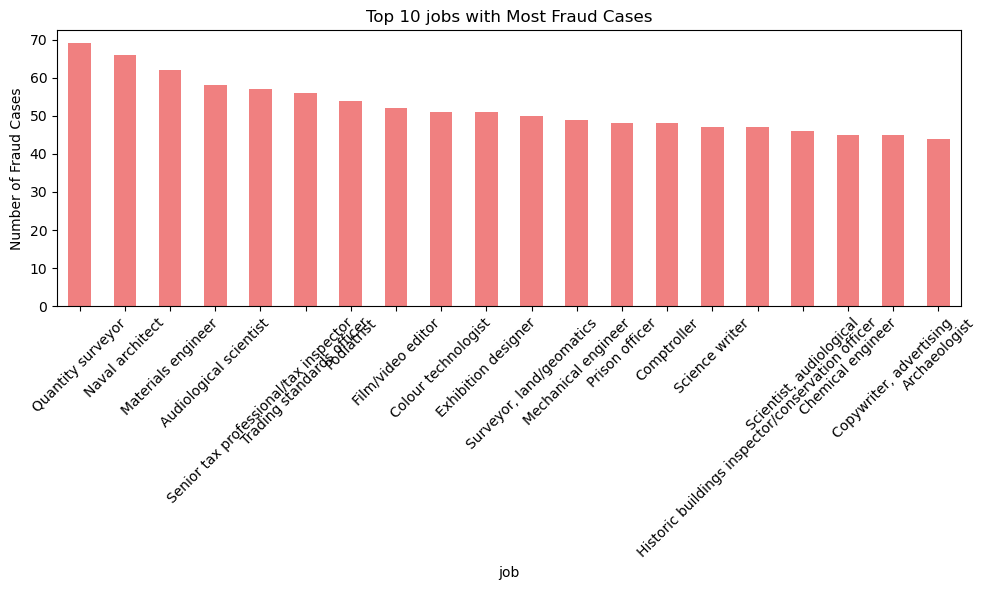

In [58]:
# Filter for fraud cases
fraud_df = full_data[full_data['is_fraud'] == 1]

# Group by street and count the occurrences
top_fraud_streets = fraud_df['job'].value_counts().head(20)

# Plotting
plt.figure(figsize=(10, 6))
top_fraud_streets.plot(kind='bar', color='lightcoral')
plt.title('Top 10 jobs with Most Fraud Cases')
plt.xlabel('job')
plt.ylabel('Number of Fraud Cases')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


<Axes: xlabel='is_fraud', ylabel='is_weekend'>

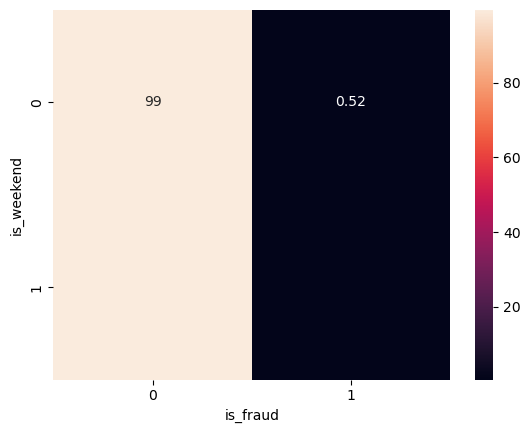

In [59]:
sns.heatmap(data=pd.crosstab(full_data["is_weekend"],full_data["is_fraud"], normalize = "index") * 100, annot = True)

<Axes: xlabel='is_fraud', ylabel='day_period'>

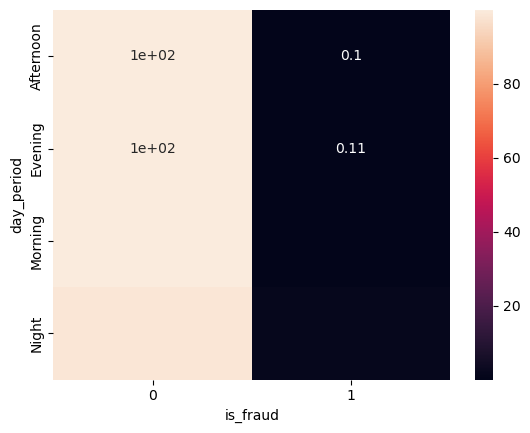

In [60]:
sns.heatmap(data=pd.crosstab(full_data["day_period"],full_data["is_fraud"], normalize = "index") * 100, annot = True)

In [61]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize the sampler
sampler = RandomUnderSampler(random_state=42)

# Separate features and target
X = full_data.drop('is_fraud', axis=1)
y = full_data['is_fraud']

# Perform random undersampling
X_resampled, y_resampled = sampler.fit_resample(X, y)

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 1. Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# 2. Define features (X) and target (y)
X = full_data[numerical + categorical]
y = full_data["is_fraud"]

# 3. Perform random undersampling
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# 4. Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Scale the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# 6. Train the Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 7. Predict
y_pred_lr = linear_model.predict(X_test)

# 8. Apply threshold (convert to binary classification)
y_pred_lr = np.where(y_pred_lr > 0.5, 1, 0)

# 9. Evaluate the Linear Regression Model
print("Linear Regression Model")
print("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_lr))
print("F1 Score: ", f1_score(y_test, y_pred_lr))
print("Recall: ", recall_score(y_test, y_pred_lr))
print("Precision: ", precision_score(y_test, y_pred_lr))


Linear Regression Model
Accuracy:  0.8231028231028231
Confusion Matrix: 
 [[1752  177]
 [ 506 1426]]
F1 Score:  0.8067892503536068
Recall:  0.7380952380952381
Precision:  0.8895820336868372


In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming `full_data`, `categorical`, and `numerical` have already been defined

# 1. Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# 2. Define features (X) and target (y)
X = full_data[numerical + categorical]
y = full_data["is_fraud"]

# 3. Perform random undersampling
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# 4. Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Scale the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# 6. Train the Decision Tree Classifier on the resampled data
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# 7. Predict on the test data
y_pred_dt = dt_model.predict(X_test)

# 8. Evaluate the Decision Tree Model
print("Decision Tree Model")
print("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dt))
print("F1 Score: ", f1_score(y_test, y_pred_dt))
print("Recall: ", recall_score(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print("\n")


Decision Tree Model
Accuracy:  0.9603729603729604
Confusion Matrix: 
 [[1852   77]
 [  76 1856]]
F1 Score:  0.9604139715394566
Recall:  0.9606625258799172
Precision:  0.9601655457837558




In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming `full_data`, `categorical`, and `numerical` have already been defined

# 1. Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# 2. Define features (X) and target (y)
X = full_data[numerical + categorical]
y = full_data["is_fraud"]

# 3. Perform random undersampling
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# 4. Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Scale the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# 6. Initialize and train Random Forest model on the resampled data
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# 7. Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# 8. Evaluate the Random Forest model
print("Random Forest Model")
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print("Recall: ", recall_score(y_test, y_pred_rf))
print("Precision: ", precision_score(y_test, y_pred_rf))


Random Forest Model
Accuracy:  0.972027972027972
Confusion Matrix: 
 [[1882   47]
 [  61 1871]]
F1 Score:  0.9719480519480519
Recall:  0.9684265010351967
Precision:  0.9754953076120959


In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming `full_data`, `categorical`, and `numerical` have already been defined

# 1. Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# 2. Define features (X) and target (y)
X = full_data[numerical + categorical]
y = full_data["is_fraud"]

# 3. Perform random undersampling
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# 4. Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Scale the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# 6. Initialize and train XGBoost model on the resampled data
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# 7. Predict on the test data
y_pred_xg = xgb_model.predict(X_test)

# 8. Evaluate the XGBoost model
print("XG Boost Model")
print("Accuracy: ", accuracy_score(y_test, y_pred_xg))
print("Classification Report:")
print(classification_report(y_test, y_pred_xg))


XG Boost Model
Accuracy:  0.9764309764309764
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1929
           1       0.97      0.98      0.98      1932

    accuracy                           0.98      3861
   macro avg       0.98      0.98      0.98      3861
weighted avg       0.98      0.98      0.98      3861



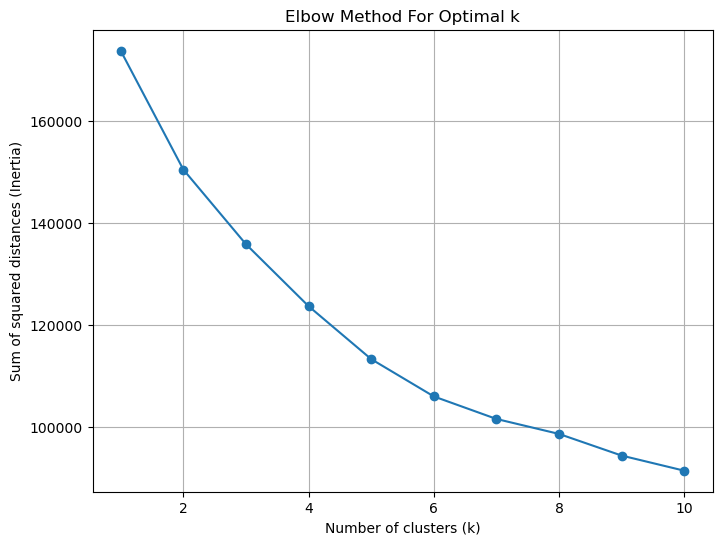

In [66]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming X_resampled is already defined from previous steps
# We will scale the resampled data first
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_resampled)

# Elbow method to determine the optimal number of clusters
sse = []  
k_range = range(1, 11)

# Calculate SSE for different values of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np

In [ ]:
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Initialize the sampler
sampler = RandomUnderSampler(random_state=42)

# Separate features and target from training data
X_train = data_train.drop('is_fraud', axis=1)
y_train = data_train['is_fraud']

# Perform random undersampling on the training data
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

# Convert labels to NumPy arrays and ensure they are of type float32
labels_train = y_resampled.astype(np.float32)
labels_test = data_test['is_fraud'].values.astype(np.float32)

# Drop non-numeric columns from features in both datasets
data_train_numeric = X_resampled.select_dtypes(include=[np.number])
data_test_numeric = data_test.select_dtypes(include=[np.number])

# Align test data columns with train data
data_test_numeric = data_test_numeric[data_train_numeric.columns]

# Convert DataFrame to NumPy arrays and ensure float32 type
data_train_np = data_train_numeric.to_numpy().astype(np.float32)
data_test_np = data_test_numeric.to_numpy().astype(np.float32)

# Print shapes and types for debugging
print(f"data_train_np shape: {data_train_np.shape}, dtype: {data_train_np.dtype}")
print(f"labels_train shape: {labels_train.shape}, dtype: {labels_train.dtype}")
print(f"data_test_np shape: {data_test_np.shape}, dtype: {data_test_np.dtype}")
print(f"labels_test shape: {labels_test.shape}, dtype: {labels_test.dtype}")

# Define parameters
time_steps = 1
number_of_features = data_train_np.shape[1]

# Reshape data for LSTM
data_train_reshaped = data_train_np.reshape(data_train_np.shape[0], time_steps, number_of_features)
data_test_reshaped = data_test_np.reshape(data_test_np.shape[0], time_steps, number_of_features)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, number_of_features)))
model.add(Dropout(0.4))  # Adjusted dropout to reduce overfitting
model.add(LSTM(25))  # Reduced complexity of the second LSTM layer
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    data_train_reshaped,
    labels_train,
    epochs=15,  # Reduced epochs to prevent overfitting
    batch_size=32,
    validation_data=(data_test_reshaped, labels_test)
)

# Evaluate the model
scores = model.evaluate(data_test_reshaped, labels_test)
print(f"Accuracy: {scores[1]}")


data_train_np shape: (15012, 10), dtype: float32
labels_train shape: (15012,), dtype: float32
data_test_np shape: (555719, 10), dtype: float32
labels_test shape: (555719,), dtype: float32
Epoch 1/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.4941 - loss: 0.6950 - val_accuracy: 0.9961 - val_loss: 0.6923
Epoch 2/15
458/470 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4924 - loss: 0.6940